In [1]:
%matplotlib inline
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac, unweighted_unifrac_fast, weighted_unifrac_fast
import pandas as pd
from qiime_default_reference import get_reference_tree
from skbio import TreeNode
from skbio.diversity._fast_base import index_tree
from biom import load_table
from skbio.diversity.beta._fast_unifrac import make_pdist, unifrac, w_unifrac
from skbio.diversity.beta import pw_distances
import numpy as np

np.random.seed(1234)

bench_data = load_table('data/AG_even10k.biom')
tree = TreeNode.read(get_reference_tree())

# correct a missing branchlength in the reference tree
for n in tree.traverse(include_self=False):
    if n.length is None:
        n.length = 0.0
        
def make_and_run_pw_distances(method, counts, otu_ids, tree, normalized=False, ids=None):
    metric, counts_array, length = make_pdist(counts, otu_ids, tree, normalized=normalized, metric=method)
    return pw_distances(metric, counts_array, ids=ids)

def get_random_samples(n, tree, shear):
    samples = bench_data.subsample(n, by_id=True)
    samples.filter(lambda v, i, md: v.sum() > 0, axis='observation')  # remove zero'd observations in place
    ids = samples.ids().copy()
    otu_ids = samples.ids(axis='observation').copy()
    otu_data = samples.matrix_data.toarray().T
    if shear:
        t = tree.shear(otu_ids)
    else:
        t = tree.copy()
        
    return ids, otu_ids, otu_data, t

Verify producing the sames results.

In [2]:
import numpy.testing as npt

ids, otu_ids, otu_data, t = get_random_samples(10, tree, True)

fu_mat = make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
u_mat = pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwu_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
wu_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwun_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
wun_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)

npt.assert_almost_equal(fu_mat.data, u_mat.data)
npt.assert_almost_equal(fwu_mat.data, wu_mat.data)
npt.assert_almost_equal(fwun_mat.data, wun_mat.data)

General timing

In [3]:
%timeit make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)

10 loops, best of 3: 33.9 ms per loop
1 loops, best of 3: 1.41 s per loop
10 loops, best of 3: 35.3 ms per loop
1 loops, best of 3: 1.54 s per loop
10 loops, best of 3: 160 ms per loop
1 loops, best of 3: 2.02 s per loop


API testing, making the same method calls and verifying results. Intentionally doing the full matrix in the (very unexpected event) that d(u, v) != d(v, u)

In [4]:
method_sets = [[unweighted_unifrac, unweighted_unifrac_fast], 
               [weighted_unifrac, weighted_unifrac_fast]]

ids, otu_ids, otu_data, t = get_random_samples(5, tree, True)

for i in range(len(otu_data)):
    for j in range(len(otu_data)):
        for method_set in method_sets:
            method_results = []
            for method in method_set:
                method_results.append(method(otu_data[i], otu_data[j], otu_ids, t))
            npt.assert_almost_equal(*method_results)

`pw_distances` scaling tests.

10 loops, best of 3: 23.5 ms per loop
10 loops, best of 3: 25.4 ms per loop
100 loops, best of 3: 11.3 ms per loop
100 loops, best of 3: 12.2 ms per loop
10 loops, best of 3: 152 ms per loop
10 loops, best of 3: 172 ms per loop
100 loops, best of 3: 18.2 ms per loop
100 loops, best of 3: 18.2 ms per loop
1 loops, best of 3: 765 ms per loop
1 loops, best of 3: 824 ms per loop
10 loops, best of 3: 29.1 ms per loop
10 loops, best of 3: 30.5 ms per loop
1 loops, best of 3: 5.36 s per loop
1 loops, best of 3: 6.06 s per loop
10 loops, best of 3: 79.3 ms per loop
10 loops, best of 3: 80.1 ms per loop
1 loops, best of 3: 21.7 s per loop
1 loops, best of 3: 23.5 s per loop
10 loops, best of 3: 119 ms per loop
10 loops, best of 3: 112 ms per loop
1 loops, best of 3: 1min 37s per loop
1 loops, best of 3: 1min 47s per loop
1 loops, best of 3: 321 ms per loop
1 loops, best of 3: 275 ms per loop


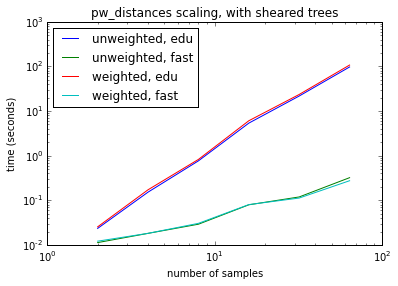

In [5]:
sample_counts = [2, 4, 8, 16, 32, 64]
uw_times = []
uwf_times = []
w_times = []
wf_times = []

for n_samples in sample_counts:
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    for times, method in [[uw_times, unweighted_unifrac], [w_times, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)

    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     
plot(sample_counts, uw_times)
plot(sample_counts, uwf_times)
plot(sample_counts, w_times)
plot(sample_counts, wf_times)
legend(['unweighted, edu', 'unweighted, fast', 'weighted, edu', 'weighted, fast'], loc=0)
title("pw_distances scaling, with sheared trees")
xlabel('number of samples')
ylabel('time (seconds)')
xscale('log')
yscale('log')
savefig('edu vs fast - pruned trees.png')

100 loops, best of 3: 13.1 ms per loop
100 loops, best of 3: 14.5 ms per loop
10 loops, best of 3: 19.6 ms per loop
100 loops, best of 3: 7.31 ms per loop
100 loops, best of 3: 7.63 ms per loop
100 loops, best of 3: 8.34 ms per loop
1 loops, best of 3: 375 ms per loop
1 loops, best of 3: 379 ms per loop
1 loops, best of 3: 395 ms per loop
1 loops, best of 3: 1.68 s per loop
1 loops, best of 3: 1.8 s per loop
1 loops, best of 3: 1.96 s per loop
10 loops, best of 3: 175 ms per loop
1 loops, best of 3: 189 ms per loop
1 loops, best of 3: 257 ms per loop
100 loops, best of 3: 19.5 ms per loop
10 loops, best of 3: 20.3 ms per loop
10 loops, best of 3: 28.5 ms per loop
1 loops, best of 3: 2.32 s per loop
1 loops, best of 3: 2.39 s per loop
1 loops, best of 3: 2.54 s per loop
1 loops, best of 3: 1.7 s per loop
1 loops, best of 3: 1.82 s per loop
1 loops, best of 3: 2.87 s per loop
1 loops, best of 3: 992 ms per loop
1 loops, best of 3: 1.08 s per loop
1 loops, best of 3: 1.42 s per loop
10 lo

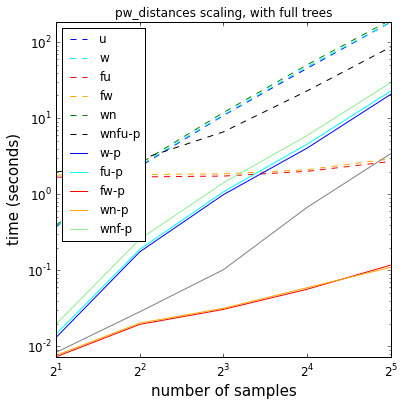

In [6]:
sample_counts = [2, 4, 8, 16, 32]

uw_times = []
uwf_times = []
w_times = []
wn_times = []
wf_times = []
wnf_times = []
uw_times_p = []
uwf_times_p = []
w_times_p = []
wn_times_p = []
wf_times_p = []
wnf_times_p = []

for n_samples in sample_counts:
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    # sheared trees
    for times, method in [[uw_times_p, unweighted_unifrac], [w_times_p, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)

    result = %timeit -o pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wn_times_p.append(result.best)
    
    for times, method in [[uwf_times_p, unifrac], [wf_times_p, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t, normalized=True)
    wnf_times_p.append(result.best)     
    
    # full trees
    for times, method in [[uw_times, unweighted_unifrac], [w_times, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)

    result = %timeit -o pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wn_times.append(result.best)    
        
    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=tree)
        times.append(result.best)     

    result = %timeit -o make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=tree, normalized=True)
    wnf_times.append(result.best)     
        
        
fig = figure(figsize=(6,6))
plot(sample_counts, uw_times, '--', color='blue')
plot(sample_counts, w_times, '--', color='cyan')
plot(sample_counts, uwf_times, '--', color='red')
plot(sample_counts, wf_times, '--', color='orange')
plot(sample_counts, wn_times, '--', color='green')
plot(sample_counts, wnf_times, '--', color='black')

plot(sample_counts, uw_times_p, color='blue')
plot(sample_counts, w_times_p, color='cyan')
plot(sample_counts, uwf_times_p, color='red')
plot(sample_counts, wf_times_p, color='orange')
plot(sample_counts, wn_times_p, color='lightgreen')
plot(sample_counts, wnf_times_p, color='grey')

legend(['u', 'w', 'fu', 'fw', 'wn', 'wnf' 'u-p', 'w-p', 'fu-p', 'fw-p', 'wn-p', 'wnf-p'], loc=2)
title("pw_distances scaling, with full trees")
xlabel('number of samples', fontsize=15)
ylabel('time (seconds)', fontsize=15)
xscale('log', basex=2)
yscale('log')
xlim(min(sample_counts), max(sample_counts))
ylim(min(uwf_times_p), max(w_times))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
savefig('edu vs fast.png')